# Covid-19 Vaccines in California and their Impacts

### Hypothesis:
#### 1.	College towns had an impact on Covid-19 surges in 2020.
#### 2.	Vaccines have directly impacted California’s case and death rates.

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import requests
from census import Census
from us import states

#import API key for US Census API
from config import api_key
c = Census(api_key)

### Cleaning Data

In [2]:
# Cleaning Cases Data
case_df = pd.read_csv("Data/covid19cases_test.csv")
case_df.head()

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,4/23/2021,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,106.0,3.0,11251.0
1,4/23/2021,Alpine,County,1117.0,0.0,0.0,NaN,NaN,0.0,0.0,2.0
2,4/23/2021,Amador,County,38531.0,0.0,0.0,NaN,NaN,4.0,0.0,487.0
3,4/23/2021,Butte,County,217769.0,0.0,0.0,NaN,NaN,16.0,0.0,454.0
4,4/23/2021,Calaveras,County,44289.0,0.0,0.0,NaN,NaN,5.0,0.0,135.0


In [3]:
# change date column to easier to compare format
case_df.date = pd.to_datetime(case_df['date'],format='%m/%d/%Y')

# filter out dates past 3-31-21, as well as rows with useless data
clean_case = case_df.loc[(case_df.date<dt.datetime(2021,4,1)) & \
                         (case_df.area != 'Out of state') & \
                         (case_df.area != 'California')& \
                         (case_df.area != 'Unknown')]

# filter out columns we dont need
clean_case = clean_case[['date','area','population','cases','deaths','total_tests','positive_tests']]

# replace missing data with 0
clean_case = clean_case.fillna(0)
clean_case

,date,area,population,cases,deaths,total_tests,positive_tests
1403,2021-03-31,Alameda,1685886.0,98.0,1.0,10553.0,123.0
1404,2021-03-31,Alpine,1117.0,0.0,0.0,3.0,0.0
1405,2021-03-31,Amador,38531.0,3.0,0.0,317.0,8.0
1406,2021-03-31,Butte,217769.0,11.0,0.0,632.0,11.0
1407,2021-03-31,Calaveras,44289.0,4.0,0.0,80.0,4.0
...,...,...,...,...,...,...,...
27322,2020-02-01,Tulare,484423.0,0.0,0.0,0.0,0.0
27323,2020-02-01,Tuolumne,52351.0,0.0,0.0,0.0,0.0
27325,2020-02-01,Ventura,852747.0,0.0,0.0,1.0,0.0
27326,2020-02-01,Yolo,223612.0,0.0,0.0,0.0,0.0


In [14]:
# Cleaning Vaccinations Data

vaccine_csv_path = "Data/covid19vaccinesbycounty.csv"
vaccine_df = pd.read_csv(vaccine_csv_path)

vaccine_df=vaccine_df.drop(columns=['cumulative_pfizer_doses',
                         'cumulative_moderna_doses','cumulative_jj_doses',
                         'cumulative_at_least_one_dose', 'california_flag'])
vaccine_df=vaccine_df.drop(vaccine_df[(vaccine_df['county']=='All CA Counties')|(vaccine_df['county']=='All CA and Non-CA Counties')|(vaccine_df['county']=='Outside California')|(vaccine_df['county']=='Unknown')].index)

vaccine_df.administered_date = pd.to_datetime(vaccine_df['administered_date'],format='%m/%d/%Y')
vaccine_df=vaccine_df.loc[(vaccine_df['administered_date']<dt.datetime(2021,4,1))].copy()
vaccine_df

,county,administered_date,total_doses,cumulative_total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
511,Alameda,2020-12-15,36,36,36,0,0,36,36,0,0,36
512,Alameda,2020-12-16,202,238,202,0,0,202,238,0,0,202
513,Alameda,2020-12-17,396,634,396,0,0,396,634,0,0,396
514,Alameda,2020-12-18,1766,2400,1765,1,0,1766,2400,0,0,1766
515,Alameda,2020-12-19,1357,3757,1357,0,0,1357,3757,0,0,1357
...,...,...,...,...,...,...,...,...,...,...,...,...
7738,Yuba,2021-03-27,461,20579,27,431,3,407,6135,53,7497,409
7739,Yuba,2021-03-28,98,20677,40,54,4,37,6115,61,7558,41
7740,Yuba,2021-03-29,293,20970,85,177,31,181,6215,112,7670,212
7741,Yuba,2021-03-30,272,21242,67,197,8,191,6333,81,7751,199


In [15]:
#Cumulative CA Vaccination dataframe:
ca_vaccinations=vaccine_df.groupby(['administered_date'],as_index=False).agg({'cumulative_total_doses':['sum']})
ca_vaccinations.columns = ca_vaccinations.columns.droplevel(1)
ca_vaccinations.administered_date = pd.to_datetime(ca_vaccinations['administered_date'],format='%m/%d/%Y')
ca_vaccinations['cumulative_doses_by_10000']=ca_vaccinations.apply(lambda row: row.cumulative_total_doses/10000,axis=1)
ca_vaccinations

,administered_date,cumulative_total_doses,cumulative_doses_by_10000
0,2020-12-15,1131,0.1131
1,2020-12-16,9241,0.9241
2,2020-12-17,34939,3.4939
3,2020-12-18,78649,7.8649
4,2020-12-19,103698,10.3698
...,...,...,...
102,2021-03-27,17641175,1764.1175
103,2021-03-28,17804547,1780.4547
104,2021-03-29,18110622,1811.0622
105,2021-03-30,18499152,1849.9152


In [5]:
# Cleaning Hospital Data

In [16]:
# Cleaning Colleges Data
college_data = pd.read_csv('Data/ca_colleges.csv')

college_data.columns = ['School_ID', 'School_name', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'County', 'Longitude', 'Latitude', 'Total_Enrollment', 'Full_time_enrollment', 
                        'Part_time_enrollment']

college_data.drop(columns=['School_ID', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'County', 'Full_time_enrollment', 
                        'Part_time_enrollment'], inplace=True)

college_data.dropna(subset=['Total_Enrollment'], inplace=True)
college_data.head()

,School_name,Longitude,Latitude,Total_Enrollment
0,Academy of Art University,-122.400578,37.787943,9812.0
1,Academy of Chinese Culture and Health Sciences,-122.269839,37.805972,133.0
3,Avalon School of Cosmetology-Alameda,-122.243566,37.764203,47.0
4,College of Alameda,-122.279303,37.781017,5667.0
5,Allan Hancock College,-120.421144,34.943716,11894.0


### Connecting API

In [17]:
states.CA.fips

'06'

In [18]:
census_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B17001_002E', 
                         'B01003_001E'), geo={'for': 'zip code tabulation area:*', 'in': 'state:06'})
census_data[0]

#Converting to DataFrame
census_df = pd.DataFrame(census_data)

census_df.rename(columns={'B19013_001E': 'Household_Income',
                         'B19301_001E': 'Income_per_Capita',
                         'B17001_002E': 'Poverty_Count', 
                         'B01003_001E': 'Population', 
                         'NAME': 'Name', 
                          'zip code tabulation area': 'Zipcode'}, inplace=True)
census_df = census_df.loc[census_df.Household_Income>0].copy()
census_df.drop(columns=['Name', 'Poverty_Count', 'state'], inplace=True)
census_df = census_df[['Zipcode', 'Household_Income', 'Income_per_Capita', 'Population']]
census_df.head()

,Zipcode,Household_Income,Income_per_Capita,Population
0,95126,92788.0,54954.0,35988.0
1,95134,139558.0,65665.0,27224.0
2,95202,14484.0,12408.0,6001.0
3,95209,78883.0,27963.0,44313.0
4,95222,52289.0,36554.0,5090.0


In [19]:
# Exporting data as csv
census_df.to_csv('Data/Census_data.csv', encoding='utf-8', index=False)

### Summary Statistics

## Research Analysis

### 1.	How has the introduction of the Covid vaccine affected case/death rate in California?

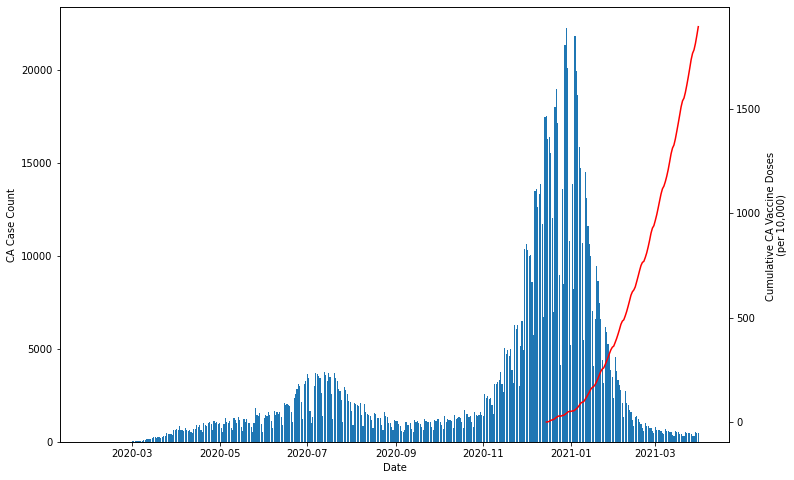

In [20]:
#Covid cases vs. vaccinations

#covid case & dates for bar graph
x1=(clean_case['date'])
y1=(clean_case['cases'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Case Count")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.show()

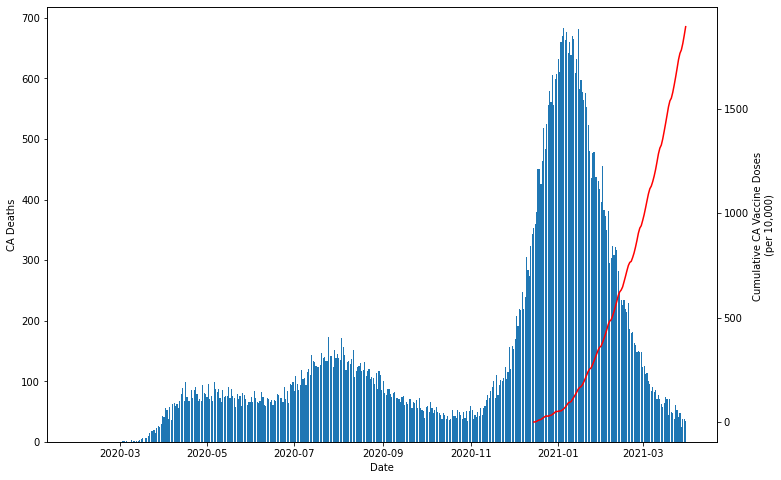

In [21]:
#covid deaths vs. vaccinations 
#
death_by_date = clean_case.groupby(['date'],as_index=False).agg({'deaths':['sum']})
death_by_date.columns = death_by_date.columns.droplevel(1)

#covid case & dates for bar graph
x1=(death_by_date['date'])
y1=(death_by_date['deaths'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Deaths")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.show()

### 2.	Do “College” towns play a larger role in case surges?

### 3.	Are there “Vaccination Deserts”? What impact have Covid-19 and the vaccines had in these areas?

### 4.	Can we predict when California will return to “normal”?